Goal: Identify best k using reconstruction error and stability metrics.

Let's identify the top 2-3 values of k using same parameters as SigprofilerExtractor and then do further optimization of other parameters.

SigProfilerExctractor:
"By default, the tool decomposes the input mutation matrix M by searching for an optimal number of mutational signatures, k, ranging from 1 to 25

For each value of k, the tool performs 100 independent NMF factorizations. During each run, the matrix M is first Poisson resampled and normalized. The decomposition is then carried out using the multiplicative update NMF algorithm, minimizing an objective function based on the Kullback-Leibler divergence.

To assess stability, custom partition clustering is applied to the 100 repetitions, using the Hungarian algorithm to compare different solutions. Stable clusters are identified, and their centroids are selected as the optimal signature solutions, ensuring robustness to input noise and the non-uniqueness of NMF."

In [1]:
import os

# change working directory to project-3 root
if os.getcwd().split('/')[-1] != 'project-3':
    os.chdir('../../')

import pandas as pd
import numpy as np
from src.models.nmf_runner import NMFDecomposer
import time
import matplotlib.pyplot as plt
import pickle
from src.models.clustering import consensus_signatures

In [ ]:
# set this to True to rerun the NMF
RERUN_NMF = True
APPEND_RESULTS = True # set this to True if you want to append results to existing results

# max K
MAX_K = 15

In [5]:
df_sbs = pd.read_csv('data/processed/BRCA.SBS96.all', sep='\t', index_col=0)
X = np.array(df_sbs)


NMF_PARAMS = {
    'resample_method': 'poisson',
    'objective_function': 'frobenius',
    'initialization_method': 'random',
    'normalization_method': 'GMM',
    'max_iter': 1000000,
    'num_factorizations': 100,
    'random_state': 42,
    'tolerance': 1e-15
}

if APPEND_RESULTS:
    with open('data/nmf_runs/01_nmf_k_selection.runs', 'rb') as f:
        results = pickle.load(f)
        print('Loaded NMF results from file to append NMF runs to', flush=True)
else:
    results = {}

if RERUN_NMF:
    start_k = len(results) + 1
    for k in range(start_k,15):
        print(f'Running NMF with k={k}', flush=True)
        NMF_PARAMS['n_components'] = k
        nmf_model = NMFDecomposer(**NMF_PARAMS, verbose=True)
        time_start = time.time()
        S_all, A_all, err_all, n_iter_all = nmf_model.run(X)
        time_end = time.time()
        results[k] = {
            'S_all': S_all,
            'A_all': A_all,
            'err_all': err_all,
            'n_iter_all': n_iter_all,
            'time': time_end - time_start
        }
        with open('data/nmf_runs/01_nmf_k_selection.runs', 'wb') as f:
            pickle.dump(results, f)
else:
    with open('data/nmf_runs/01_nmf_k_selection.runs', 'rb') as f:
        results = pickle.load(f)
        print('Loaded NMF results from file', flush=True)


Running NMF with k=1
Running NMF with following parameters:
n_components: 1
random_state: 42
objective_function: frobenius
num_factorizations: 100
resample_method: poisson
normalization_method: GMM
initialization_method: random
tolerance: 1e-15
max_iter: 1000000
verbose: True

Running NMF factorization k=1, iteration=1/100


Running NMF factorization k=1, iteration=2/100
Running NMF factorization k=1, iteration=3/100
Running NMF factorization k=1, iteration=4/100
Running NMF factorization k=1, iteration=5/100
Running NMF factorization k=1, iteration=6/100
Running NMF factorization k=1, iteration=7/100
Running NMF factorization k=1, iteration=8/100
Running NMF factorization k=1, iteration=9/100
Running NMF factorization k=1, iteration=10/100
Running NMF factorization k=1, iteration=11/100
Running NMF factorization k=1, iteration=12/100
Running NMF factorization k=1, iteration=13/100
Running NMF factorization k=1, iteration=14/100
Running NMF factorization k=1, iteration=15/100
Running NMF factorization k=1, iteration=16/100
Running NMF factorization k=1, iteration=17/100
Running NMF factorization k=1, iteration=18/100
Running NMF factorization k=1, iteration=19/100
Running NMF factorization k=1, iteration=20/100
Running NMF factorization k=1, iteration=21/100
Running NMF factorization k=1, iteration=22/100


KeyboardInterrupt: 

In [15]:
results = {}

len(results)

0

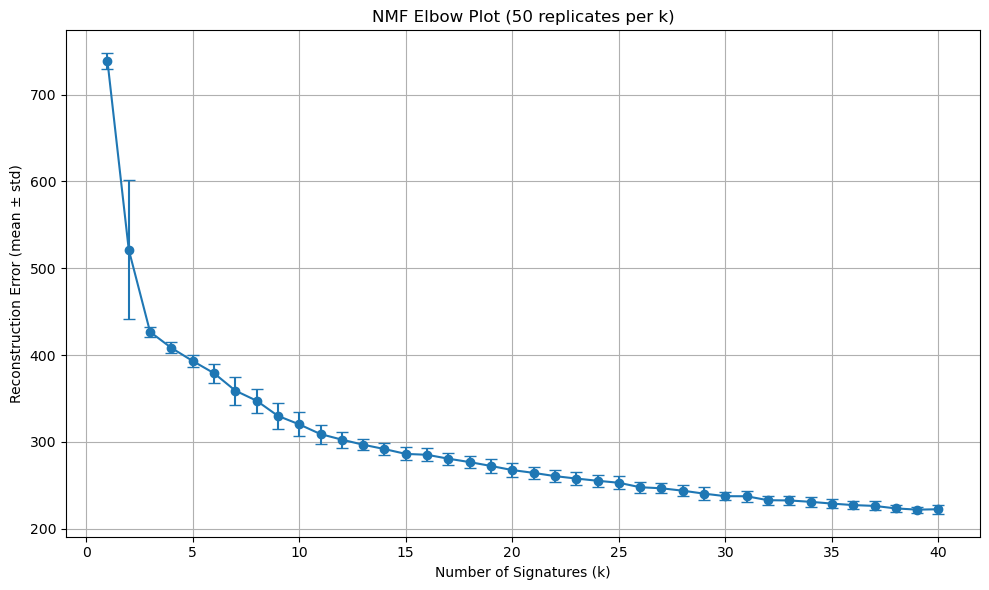

In [ ]:
# Extract reconstruction error stats
ks = sorted(results.keys())
mean_errors = [results[k]['err_all'].mean() for k in ks]
std_errors = [results[k]['err_all'].std() for k in ks]

# Elbow plot
plt.figure(figsize=(10, 6))
plt.errorbar(ks, mean_errors, yerr=std_errors, fmt='-o', capsize=4)
plt.xlabel('Number of Signatures (k)')
plt.ylabel('Reconstruction Error (mean ± std)')
plt.title(f'NMF Elbow Plot ({NMF_PARAMS['num_factorizations']} replicates per k)')
plt.grid(True)
plt.tight_layout()
plt.show()


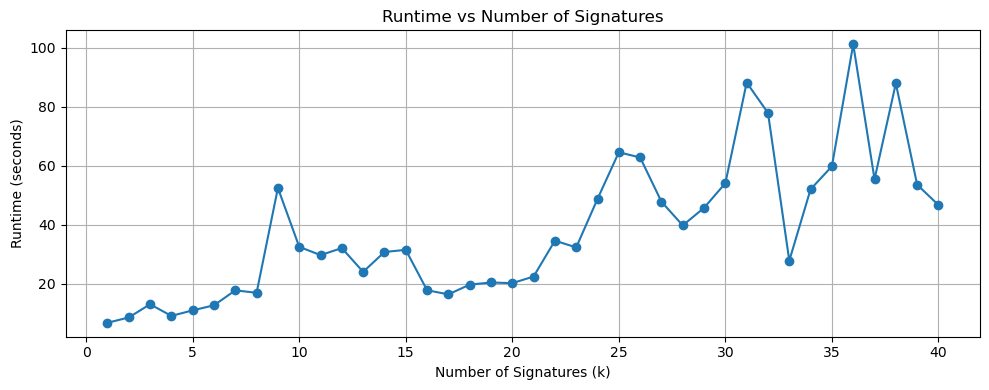

In [5]:
times = [results[k]['time'] for k in ks]

plt.figure(figsize=(10, 4))
plt.plot(ks, times, marker='o')
plt.xlabel('Number of Signatures (k)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Number of Signatures')
plt.grid(True)
plt.tight_layout()
plt.show()


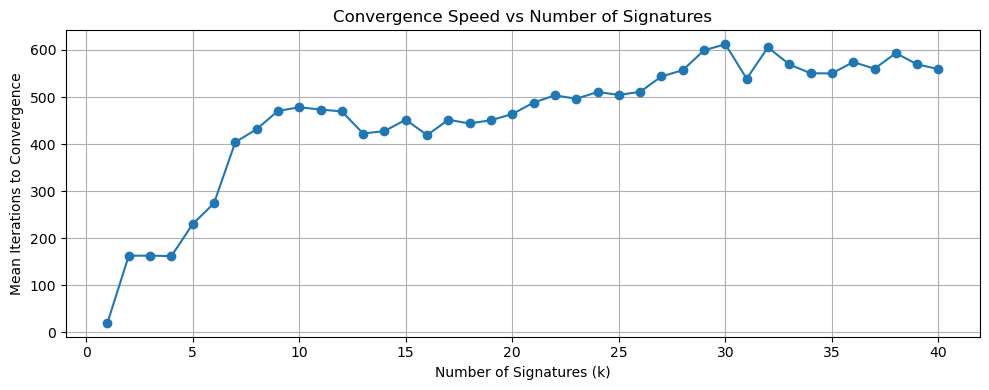

In [6]:
mean_iters = [results[k]['n_iter_all'].mean() for k in ks]

plt.figure(figsize=(10, 4))
plt.plot(ks, mean_iters, marker='o')
plt.xlabel('Number of Signatures (k)')
plt.ylabel('Mean Iterations to Convergence')
plt.title('Convergence Speed vs Number of Signatures')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# TODO: alex plots
centroids_s, sil_score_s = consensus_signatures(X, S_all, k = 25, average_threshold=0.8, minimum_threshold=0.2, reconstruction=False)

NameError: name 'S_all' is not defined

Choose 2-3 of best k (based on elbow plot and stability of signatures across 100 replicates) and run with more stringent parameters:
- lower tolerance to 1e-8 or 1e-10
- objective_function='kullback-leibler'
- increase max_iter